In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, LeakyReLU, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
def loaddir(path):
    images = []
    for file in os.listdir(path):
        images.append(cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_RGB2BGR))
        if len(images) == 5000:
            break
    return np.array(images)

def traintestsplit(smalldata, mediumdata, largedata):
    assert(len(smalldata) == len(largedata))
    indicies = [i for i in range(len(smalldata))]
    np.random.seed(0)
    np.random.shuffle(indicies)
    testindices = indicies[:len(indicies) // 5]
    trainindices = indicies[len(indicies) // 5:]
    smalltest = smalldata[testindices]
    smalltrain = smalldata[trainindices]
    mediumtest = mediumdata[testindices]
    mediumtrain = mediumdata[trainindices]
    largetest = largedata[testindices]
    largetrain = largedata[trainindices]
    return (smalltrain, mediumtrain, largetrain), (smalltest, mediumtest, largetest)

In [3]:
(X, y1, y2), (X_test, y_test1, y_test2) = traintestsplit(loaddir('./img_align_celeba_32/'), loaddir('./img_align_celeba_64/'), loaddir('./img_align_celeba_128/'))

In [30]:
def normalize_imgs(img):
    return (img - 127.5)/127.5

def unnormalize_imgs(img):
    return np.clip((img + 1.) / 2., a_min=0., a_max=1.)

In [5]:
X = normalize_imgs(X)
X_test = normalize_imgs(X_test)
y1 = normalize_imgs(y1)
y_test1 = normalize_imgs(y_test1)
y2 = normalize_imgs(y2)
y_test2 = normalize_imgs(y_test2)

In [6]:
def build_model(name):
    img_input = Input(shape=(128, 128, 3))
    x1 = Conv2D(64, 3, strides=(1, 1), padding='same', activity_regularizer=regularizers.l1(10e-10))(img_input)
    x1 = LeakyReLU()(x1)
    x1 = Conv2D(64, 3, strides=(2, 2), padding='same', activity_regularizer=regularizers.l1(10e-10))(x1)
    x1 = LeakyReLU()(x1)
    x2 = Conv2D(128, 3, strides=(1, 1), padding='same', activity_regularizer=regularizers.l1(10e-10))(x1)
    x2 = LeakyReLU()(x2)
    x2 = Conv2D(128, 3, strides=(2, 2), padding='same', activity_regularizer=regularizers.l1(10e-10))(x2)
    x2 = LeakyReLU()(x2)
    x3 = Conv2D(256, 3, strides=(2, 2), padding='same', activity_regularizer=regularizers.l1(10e-10))(x2)
    x3 = LeakyReLU()(x3)    
    
    x4 = Conv2DTranspose(128, 3, strides=(2, 2), padding='same', activity_regularizer=regularizers.l1(10e-10))(x3)
    x4 = LeakyReLU()(x4)
    x4 = Conv2DTranspose(128, 3, strides=(1, 1), padding='same', activity_regularizer=regularizers.l1(10e-10))(x4)
    x4 = LeakyReLU()(x4)
    x4 = Add()([x4, x2])
    x5 = Conv2DTranspose(64, 3, strides=(2, 2), padding='same', activity_regularizer=regularizers.l1(10e-10))(x4)
    x5 = LeakyReLU()(x5)
    x5 = Conv2DTranspose(64, 3, strides=(1, 1), padding='same', activity_regularizer=regularizers.l1(10e-10))(x5)
    x5 = LeakyReLU()(x5)
    x5 = Add()([x5, x1])
    x6 = Conv2DTranspose(3, 3, strides=(2, 2), padding='same', activity_regularizer=regularizers.l1(10e-10))(x5)
    x6 = LeakyReLU()(x6)
    
    return Model(img_input, x6, name=name)

In [7]:
def build_combined_model():
    # 32->64 + 64->128
    # Both identical architecture
    inp = Input(shape=(128, 128, 3))
    m1 = build_model('ae1')(inp)
    m2 = build_model('ae2')(m1)
    m = Model(inp, [m1, m2], name='combinedae')
    m.summary()
    return m

In [8]:
opt = Adam(learning_rate=5e-4)
model = build_combined_model()
model.compile(loss=['mse', 'mse'],
              optimizer=opt,
              metrics=['accuracy'])

Model: "combinedae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae1 (Model)                  (None, 128, 128, 3)       1110403   
_________________________________________________________________
ae2 (Model)                  (None, 128, 128, 3)       1110403   
Total params: 2,220,806
Trainable params: 2,220,806
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.layers[1].summary()
model.layers[2].summary()

Model: "ae1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       leaky_re_lu[0][0]                
________________________________________________________________________________________________

In [10]:
history = model.fit(X, [y1, y2],
              batch_size=32,
              epochs=50,
              validation_data=(X_test, [y_test1, y_test2]),
              shuffle=True)

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 41s 10ms/sample - loss: 0.1090 - ae1_loss: 0.0430 - ae2_loss: 0.0641 - ae1_accuracy: 0.7587 - ae2_accuracy: 0.7476 - val_loss: 0.0312 - val_ae1_loss: 0.0096 - val_ae2_loss: 0.0195 - val_ae1_accuracy: 0.8388 - val_ae2_accuracy: 0.8129
Epoch 2/50
4000/4000 [==============================] - 37s 9ms/sample - loss: 0.0255 - ae1_loss: 0.0074 - ae2_loss: 0.0161 - ae1_accuracy: 0.8574 - ae2_accuracy: 0.8379 - val_loss: 0.0230 - val_ae1_loss: 0.0063 - val_ae2_loss: 0.0147 - val_ae1_accuracy: 0.8751 - val_ae2_accuracy: 0.8507
Epoch 3/50
4000/4000 [==============================] - 38s 9ms/sample - loss: 0.0200 - ae1_loss: 0.0052 - ae2_loss: 0.0129 - ae1_accuracy: 0.8737 - ae2_accuracy: 0.8516 - val_loss: 0.0181 - val_ae1_loss: 0.0046 - val_ae2_loss: 0.0116 - val_ae1_accuracy: 0.8731 - val_ae2_accuracy: 0.8466
Epoch 4/50
4000/4000 [==============================] - 38s 9ms/sample - loss: 0.016

4000/4000 [==============================] - 39s 10ms/sample - loss: 0.0098 - ae1_loss: 0.0020 - ae2_loss: 0.0070 - ae1_accuracy: 0.9248 - ae2_accuracy: 0.9150 - val_loss: 0.0100 - val_ae1_loss: 0.0021 - val_ae2_loss: 0.0072 - val_ae1_accuracy: 0.9089 - val_ae2_accuracy: 0.8933
Epoch 30/50
4000/4000 [==============================] - 39s 10ms/sample - loss: 0.0097 - ae1_loss: 0.0020 - ae2_loss: 0.0069 - ae1_accuracy: 0.9259 - ae2_accuracy: 0.9159 - val_loss: 0.0100 - val_ae1_loss: 0.0021 - val_ae2_loss: 0.0072 - val_ae1_accuracy: 0.9146 - val_ae2_accuracy: 0.9057
Epoch 31/50
4000/4000 [==============================] - 39s 10ms/sample - loss: 0.0098 - ae1_loss: 0.0020 - ae2_loss: 0.0070 - ae1_accuracy: 0.9221 - ae2_accuracy: 0.9072 - val_loss: 0.0099 - val_ae1_loss: 0.0021 - val_ae2_loss: 0.0071 - val_ae1_accuracy: 0.9208 - val_ae2_accuracy: 0.9099
Epoch 32/50
4000/4000 [==============================] - 39s 10ms/sample - loss: 0.0096 - ae1_loss: 0.0020 - ae2_loss: 0.0069 - ae1_accurac

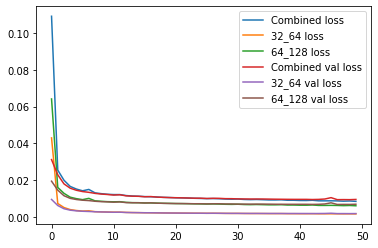

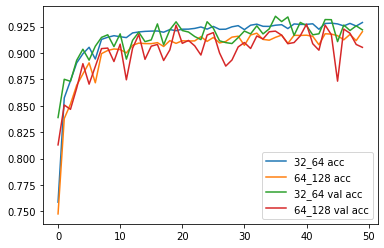

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['ae1_loss'])
plt.plot(history.history['ae2_loss'])

plt.plot(history.history['val_loss'])
plt.plot(history.history['val_ae1_loss'])
plt.plot(history.history['val_ae2_loss'])
plt.legend(['Combined loss','32_64 loss', '64_128 loss', 'Combined val loss','32_64 val loss', '64_128 val loss'])
plt.show()

# plt.plot(history.history['accuracy'])
plt.plot(history.history['ae1_accuracy'])
plt.plot(history.history['ae2_accuracy'])

# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_ae1_accuracy'])
plt.plot(history.history['val_ae2_accuracy'])
plt.legend(['32_64 acc', '64_128 acc','32_64 val acc', '64_128 val acc'])
plt.show()


In [25]:
def infer(model, input_img):
    return model.predict(np.array([input_img]))

In [70]:
def results(x, y, m):
    

    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                     axes_pad=0,  # pad between axes in inch.
                     )
    indices = [random.randint(0, len(x) - 1) for i in range(len(x))]
    for n, ax in enumerate(grid):
        i = n % 4
        j = (n // 4) % 4
        if i == 0:
            ax.imshow(unnormalize_imgs(x[indices[j]]))
            if j == 0:
                ax.set_title('Input')
        elif i == 1:
            ax.imshow(unnormalize_imgs(infer(m, x[indices[j]])[0][0]))
            if j == 0:
                ax.set_title('AE1 Output')
        elif i == 2:
            ax.imshow(unnormalize_imgs(infer(m, x[indices[j]])[1][0]))
            if j == 0:
                ax.set_title('AE2 Output')
        elif i == 3:
            ax.imshow(unnormalize_imgs(y[indices[j]]))
            if j == 0:
                ax.set_title('Actual')
        
        ax.axis('off')
        
    fig.show()

C:\Users\woodw\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


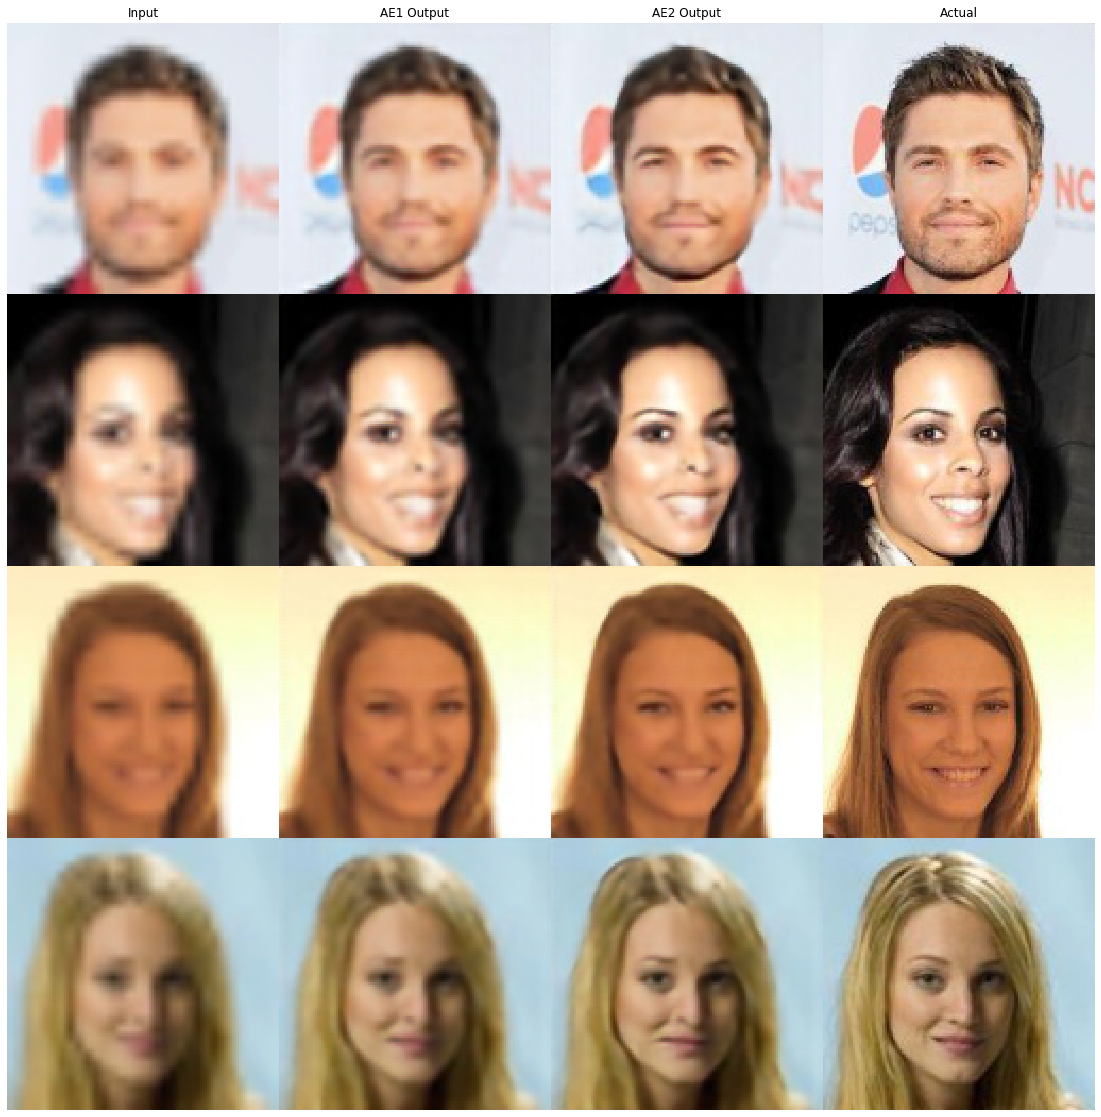

In [80]:
results(X_test, y_test2, model)

In [15]:
model.predict(np.array([X[0]]))[0]

array([[[[-0.78228825, -0.8138753 , -0.8469544 ],
         [-0.97602993, -0.9152905 , -1.0188363 ],
         [-0.95565844, -0.9561742 , -1.0331637 ],
         ...,
         [-0.64608437, -0.58959186, -0.8331025 ],
         [-0.6152966 , -0.5728147 , -0.79073626],
         [-0.5643118 , -0.50854796, -0.71993554]],

        [[-0.9836603 , -0.9764736 , -0.98216313],
         [-1.0216147 , -1.0161306 , -1.0446348 ],
         [-0.98081106, -0.9502621 , -0.99993044],
         ...,
         [-0.64927864, -0.5439872 , -0.8296007 ],
         [-0.6652808 , -0.5958951 , -0.8623086 ],
         [-0.65571296, -0.5736279 , -0.8208916 ]],

        [[-1.0062585 , -0.97808594, -1.0166388 ],
         [-0.9944121 , -0.96856457, -1.0186636 ],
         [-0.9655209 , -0.8968662 , -0.97370714],
         ...,
         [-0.63593274, -0.5239547 , -0.8379416 ],
         [-0.63875353, -0.56411016, -0.8337    ],
         [-0.63258594, -0.53595626, -0.8202429 ]],

        ...,

        [[-0.27066115, -0.4579778 , -0

In [ ]:
model.outputs

In [ ]:
y2.shape

In [ ]:
X.shape